In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = "../data"

attempt_files = [f for f in os.listdir(data_dir) if f.startswith("attempt") and f.endswith(".csv")]

summary = []

for f in attempt_files:
    path = os.path.join(data_dir, f)
    try:
        df = pd.read_csv(path)
        summary.append({"attempt": f, "tries": len(df)})
    except Exception as e:
        summary.append({"attempt": f, "tries": None, "error": str(e)})

summary_df = pd.DataFrame(summary).sort_values("attempt").reset_index(drop=True)

print(f"Total attempts: {len(summary_df)}")
display(summary_df.head(10))   # first 10
print("Average tries per attempt:", summary_df['tries'].mean())


Total attempts: 3


,attempt,tries
0,attempt1.csv,2
1,attempt2.csv,4
2,attempt3.csv,3


Average tries per attempt: 3.0


In [3]:
# Combine all attempt files
all_data = []

for f in attempt_files:
    path = os.path.join(data_dir, f)
    try:
        df = pd.read_csv(path)
        df["attempt_file"] = f
        all_data.append(df)
    except Exception as e:
        print(f"Skipping {f}: {e}")

if all_data:
    combined = pd.concat(all_data, ignore_index=True)

    # overall average
    overall_avg = combined["time"].mean()
    print(f"Overall average reaction time: {overall_avg:.3f} seconds\n")

    # per-attempt averages
    per_attempt_avg = (
        combined.groupby("attempt_file")["time"]
        .mean()
        .reset_index(name="avg_time")
        .sort_values("attempt_file")
    )

    display(per_attempt_avg.head(5))
else:
    print("No data found.")


Overall average reaction time: 1.446 seconds



,attempt_file,avg_time
0,attempt1.csv,1.013000
1,attempt2.csv,1.363250
2,attempt3.csv,1.845333


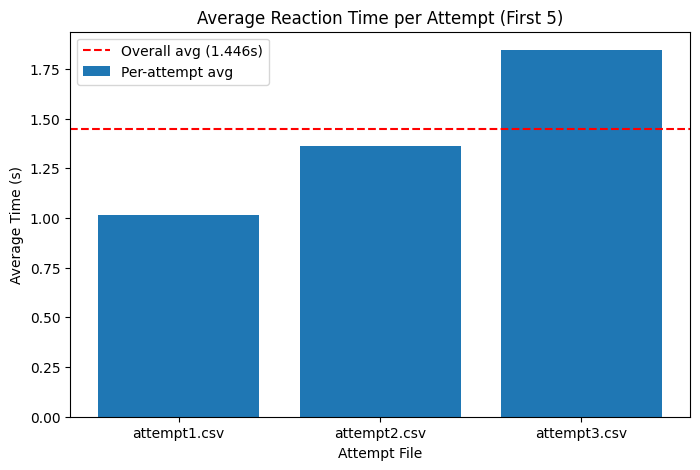

In [4]:
if all_data:
    # Take first 5 per-attempt averages
    subset = per_attempt_avg.head(5)

    plt.figure(figsize=(8,5))
    plt.bar(subset["attempt_file"], subset["avg_time"], label="Per-attempt avg")
    plt.axhline(overall_avg, color="red", linestyle="--", label=f"Overall avg ({overall_avg:.3f}s)")
    plt.ylabel("Average Time (s)")
    plt.xlabel("Attempt File")
    plt.title("Average Reaction Time per Attempt (First 5)")
    plt.legend()
    plt.show()
else:
    print("No data available to plot.")


In [5]:
combined["is_correct"] = combined["result"].astype(str).str.lower().str.startswith("correct")

# overall
overall_correct = int(combined["is_correct"].sum())
overall_tries = int(len(combined))
overall_acc = overall_correct / overall_tries if overall_tries else 0.0
print(f"Overall: {overall_correct} correct out of {overall_tries} tries ({overall_acc:.2%})")

# per-attempt (show first 5)
per_attempt_correct = (
    combined.groupby("attempt_file")["is_correct"]
    .agg(correct="sum", tries="count")
    .reset_index()
    .assign(accuracy=lambda df: df["correct"] / df["tries"])
    .sort_values("attempt_file")
)
display(per_attempt_correct.head(5))


Overall: 6 correct out of 9 tries (66.67%)


,attempt_file,correct,tries,accuracy
0,attempt1.csv,1,2,0.500000
1,attempt2.csv,3,4,0.750000
2,attempt3.csv,2,3,0.666667


In [6]:
# save overall results
correct_overall = pd.DataFrame([{
    "correct": overall_correct,
    "tries": overall_tries,
    "accuracy": overall_acc
}])

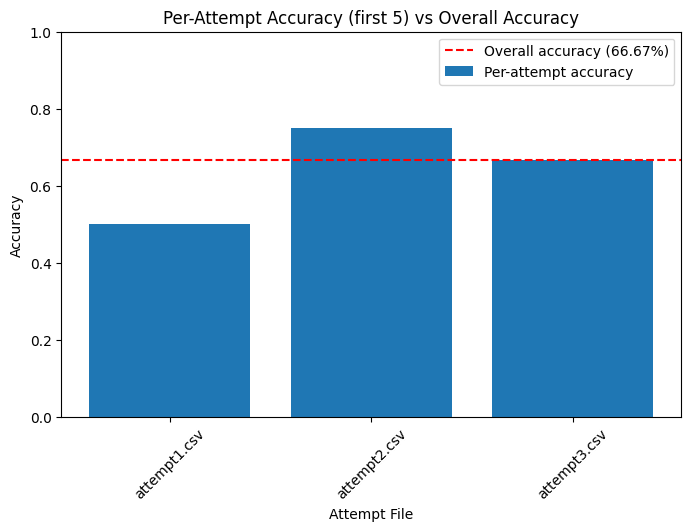

In [7]:
# Extract overall accuracy from the correct_overall DataFrame
overall_accuracy = correct_overall.loc[0, "accuracy"]

# Plot per-attempt accuracy (first 5) vs overall accuracy
subset_acc = per_attempt_correct.head(5)

plt.figure(figsize=(8,5))
plt.bar(subset_acc["attempt_file"], subset_acc["accuracy"], label="Per-attempt accuracy")
plt.axhline(overall_accuracy, linestyle="--", color="red", 
            label=f"Overall accuracy ({overall_accuracy:.2%})")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.xlabel("Attempt File")
plt.title("Per-Attempt Accuracy (first 5) vs Overall Accuracy")
plt.xticks(rotation=45)
plt.legend()
plt.show()
